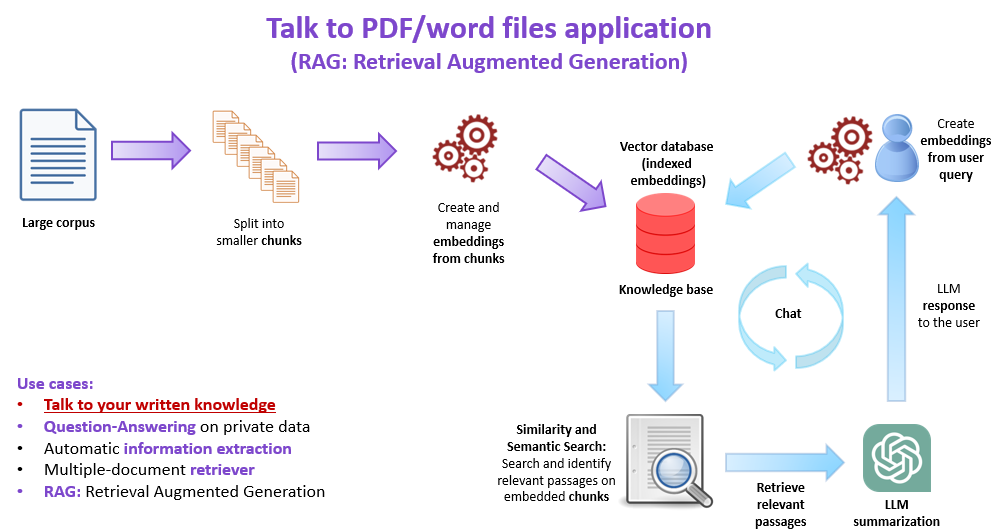

img source: HinePo

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c2f81e41-9db0-7c0e-a2b1-741d4c2bdcf2)
GPU 1: Tesla T4 (UUID: GPU-6fb13f69-5760-8c84-3b14-f4a910a8f8e0)


# Installs

In [2]:
%%time

from IPython.display import clear_output

! pip install sentence_transformers==2.2.2

! pip install -qq -U langchain
! pip install -qq -U tiktoken
! pip install -qq -U pypdf
! pip install -qq -U faiss-gpu
! pip install -qq -U InstructorEmbedding 

! pip install -qq -U transformers 
! pip install -qq -U accelerate
! pip install -qq -U bitsandbytes
! pip install -qq -U langchain-community

clear_output()

CPU times: user 2.18 s, sys: 471 ms, total: 2.65 s
Wall time: 2min 44s


# Imports

In [3]:
%%time

import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

### loaders
from langchain.document_loaders import PyPDFLoader, DirectoryLoader

### splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

### prompts
from langchain import PromptTemplate, LLMChain

### vector stores
from langchain.vectorstores import FAISS

### models
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings

### retrievers
from langchain.chains import RetrievalQA

import torch
import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)

clear_output()

CPU times: user 6.03 s, sys: 1.26 s, total: 7.29 s
Wall time: 12.9 s


In [4]:
print('langchain:', langchain.__version__)
print('torch:', torch.__version__)
print('transformers:', transformers.__version__)

langchain: 0.2.1
torch: 2.0.0
transformers: 4.41.1


In [5]:
sorted(glob.glob('./data-ielts/*'))

[]

# CFG

- CFG class enables easy and organized experimentation 

In [7]:
class CFG:
    # LLMs
    model_name = 'llama2-7b-chat' # wizardlm, llama2-7b-chat, llama2-13b-chat, mistral-7B
    temperature = 0
    top_p = 0.95
    repetition_penalty = 1.15    

    # splitting
    split_chunk_size = 800
    split_overlap = 0
    
    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'    

    # similar passages
    k = 5
    
    # paths
    PDFs_path = './data-ielts/'
    Embeddings_path =  '/kaggle/input/faiss-ielts-embedding-data'
    Output_folder = './ielts-documents-vectordb'

# Define model

In [8]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )        

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True
        )
        
        max_len = 1024

    elif model == 'llama2-7b-chat':
        model_repo = 'daryl149/llama-2-7b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )
        
        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )
        
        max_len = 2048

    elif model == 'llama2-13b-chat':
        model_repo = 'daryl149/llama-2-13b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )
                
        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,       
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )
        
        max_len = 2048 # 8192

    elif model == 'mistral-7B':
        model_repo = 'mistralai/Mistral-7B-v0.1'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )        

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
        )
        
        max_len = 1024

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [9]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

clear_output()

CPU times: user 32.8 s, sys: 1min, total: 1min 33s
Wall time: 4min 16s


In [10]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    

In [11]:
### check how Accelerate split the model across the available devices (GPUs)
# model.hf_device_map

# 🤗 pipeline

- Hugging Face pipeline

In [12]:
### hugging face pipeline
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
#     do_sample = True,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

### langchain pipeline
llm = HuggingFacePipeline(pipeline = pipe)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(


In [13]:
llm

HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x7ee994462320>)

In [14]:
# %%time
# ### testing model, not using the harry potter books yet
# ### answer is not necessarily related to harry potter
# query = "Give me information of 5 longest bridges in the world"
# llm.invoke(query)

# 🦜🔗 Langchain

- Multiple document retriever with LangChain

In [15]:
CFG.model_name

'llama2-13b-chat'

# Loader

- [Directory loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory) for multiple files
- This step is not necessary if you are just loading the vector database
- This step is necessary if you are creating embeddings. In this case you need to:
    - load de PDF files
    - split into chunks
    - create embeddings
    - save the embeddings in a vector store
    - After that you can just load the saved embeddings to do similarity search with the user query, and then use the LLM to answer the question
    
You can comment out this section if you use the embeddings I already created.

In [16]:
%%time

loader = DirectoryLoader(
    CFG.PDFs_path,
    glob="./*.pdf",
    loader_cls=PyPDFLoader,
    show_progress=True,
    use_multithreading=True
)

documents = loader.load()

100%|██████████| 2/2 [00:36<00:00, 18.09s/it]

CPU times: user 35.9 s, sys: 27.7 ms, total: 35.9 s
Wall time: 36.2 s


In [17]:
print(f'We have {len(documents)} pages in total')

We have 568 pages in total


# Splitter

- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/reference/modules/document_loaders.html?highlight=RecursiveCharacterTextSplitter#langchain.document_loaders.MWDumpLoader)

In [18]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.split_chunk_size,
    chunk_overlap = CFG.split_overlap
)

texts = text_splitter.split_documents(documents)

print(f'We have created {len(texts)} chunks from {len(documents)} pages')

We have created 2150 chunks from 568 pages


# Create Embeddings


- Embedd and store the texts in a Vector database (FAISS)
- [LangChain Vector Stores docs](https://python.langchain.com/docs/modules/data_connection/vectorstores/)
- [FAISS - langchain](https://python.langchain.com/docs/integrations/vectorstores/faiss)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks - paper Aug/2019](https://arxiv.org/pdf/1908.10084.pdf)
- [This is a nice 4 minutes video about vector stores](https://www.youtube.com/watch?v=dN0lsF2cvm4)

___

- If you use Chroma vector store it will take ~35 min to create embeddings
- If you use FAISS vector store on GPU it will take just ~3 min

___

We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search. 

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from [here](https://www.kaggle.com/datasets/hinepo/faiss-hp-sentence-transformers).

In [19]:
%%time

### we create the embeddings only if they do not exist yet
if not os.path.exists(CFG.Embeddings_path + '/index.faiss'):

    ### download embeddings model
    embeddings = HuggingFaceInstructEmbeddings(
        model_name = CFG.embeddings_model_repo,
        model_kwargs = {"device": "cuda"}
    )

    ### create embeddings and DB
    vectordb = FAISS.from_documents(
        documents = texts, 
        embedding = embeddings
    )

    ### persist vector database
    vectordb.save_local(f"{CFG.Output_folder}/faiss_index_hp") # save in output folder
#     vectordb.save_local(f"{CFG.Embeddings_path}/faiss_index_hp") # save in input folder

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 10.6 ms


If creating embeddings, remember that on Kaggle we can not write data to the input folder.

So just write (save) the embeddings to the output folder and then load them from there.

# Load vector database

- After saving the vector database, we just load it from the Kaggle Dataset I mentioned
- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [20]:
%%time

### download embeddings model
embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

### load vector DB embeddings
vectordb = FAISS.load_local(
    CFG.Embeddings_path, # from input folder
#     CFG.Output_folder + '/faiss_index_hp', # from output folder
    embeddings,
    allow_dangerous_deserialization = True
)

clear_output()

CPU times: user 1.44 s, sys: 238 ms, total: 1.68 s
Wall time: 5.08 s


# Prompt Template

- Custom prompt

In [22]:
prompt_template = """
Suppose you are a virtual evaluator with expertise in English composition. Your role
is to recommend the knowledge in English provided through given documents. 
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template, 
    input_variables = ["context", "question"]
)

# Retriever chain

- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)

In [23]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever, 
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

# Post-process outputs

- Format llm response
- Cite sources (PDFs)
- Change `width` parameter to format the output

In [24]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    
    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4]
            + ' - page: '
            + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )
    
    answer_start = ans.find("Question:")
    
    # Extract the text after "Answer:" until a blank line is found
    ans = ans[answer_start:]
    
    ans = ans + '\n\nSources: \n' + sources_used
    
    return ans

In [25]:
def llm_ans(query):
    start = time.time()
    
    llm_response = qa_chain.invoke(query)
    ans = process_llm_response(llm_response)
    
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    clear_output()
    return ans + time_elapsed_str

# Ask questions

- Question Answering from multiple documents
- Invoke QA Chain
- Talk to your data

In [26]:
CFG.model_name

'llama2-13b-chat'

In [27]:
query = "What words can replace 'beautiful'"
ans = llm_ans(query)
print(ans)

Question: What words can replace 'beautiful'
Answer: Gorgeous, Pretty, Attractive

Sources: 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 26 
4_English_Vocabulary_In_Use_Advanced_Cambridge_-_Third_Edition - page: 49 
4_English_Vocabulary_In_Use_Advanced_Cambridge_-_Third_Edition - page: 106 
4_English_Vocabulary_In_Use_Advanced_Cambridge_-_Third_Edition - page: 138 
4_English_Vocabulary_In_Use_Advanced_Cambridge_-_Third_Edition - page: 137 
4_English_Vocabulary_In_Use_Advanced_Cambridge_-_Third_Edition - page: 137

Time elapsed: 5 s


In [28]:
query = "How to use passive sentence in English"
print(llm_ans(query))

Question: How to use passive sentence in English
Answer: To use a passive sentence in English, you need to identify the subject of the sentence and then convert it into a passive form by using a form of "to be" + past participle of the main verb. For example, "The ball was thrown by John" can be converted into a passive sentence by saying "John threw the ball." Additionally, you can also use adjectives or nouns to describe the subject before converting it into a passive form.

Sources: 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 199 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 201 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 115 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 205 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 121 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 168

In [72]:
query = "How to understand the topic of an IELTS Writing task 2"
print(llm_ans(query))

Question: How to understand the topic of an IELTS Writing task 2
Answer: To understand the topic of an IELTS Writing task 2, you should first read the prompt carefully and take note of any specific instructions or requirements. Then, brainstorm ideas related to the topic and plan your essay by identifying the main points you want to make and supporting details. Finally, write your essay using clear and coherent language, and be sure to address all parts of the prompt.

Sources: 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 199 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 115 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 73 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 237 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 233 
2_English_Vocabulary_In_Use_Pre-Intermediate_Cambridge_-_Fourth_Edition - page: 220

Time el

In [73]:
query = "Give me 5 idioms worth using in many cases"
print(llm_ans(query))

Question: Give me 5 idioms worth using in many cases
Answer: Sure! Here are five idioms that could be useful in many cases:

1. "Take something on board" - to accept and consider someone else's ideas or suggestions.

Example sentence: "I took my colleague's suggestion on board and decided to change the project plan."

2. "Tighten our belts" - to reduce spending or cut back on unnecessary expenses.

Example sentence: "We need to tighten our belts and save money during these tough economic times."

3. "Move the goalposts" - to change the rules or requirements unexpectedly.

Example sentence: "The company kept moving the goalposts when it came to completing the project, making it impossible to finish on time."

4. "Hold the reins" - to have control over something or someone.

Example sentence: "As the team leader, I had to hold the reins and make sure everyone stayed on track to meet the deadline."

5. "On track" - to be making progress towards a goal or objective.

Example sentence: "I'm